# Imports

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import copy 
from tqdm.auto import tqdm as pbar

from scipy.integrate import quad
from scipy.special import erf
from scipy.interpolate import griddata
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor as RF
import pandas as pd
import seaborn as sns 

plt.style.use('./style_sheet.mplstyle')
im_colors = np.array([[146, 149, 145, 64], [132, 0, 0, 255]]) / 255
state_colors = np.array([[81,112,216,255], [146, 149, 145, 127], [230,0,0,255], [132, 0, 0, 255]]) / 255


ToDo:
* Correlated inputs?

# Hyperparameters

In [2]:
nb_inputs = 30
nb_arc = np.repeat([0, 1], nb_inputs // 2)
nb_hidden = 1
nb_steps = 90
batch_size = 3  # unimodal, unimodal and multimodal
ms = 0.001
n_repeats = 10  # simulation repeats

weight_means = np.linspace(0.0, 0.5, 25)
tau_ms = np.linspace(1e-3, 20e-3, 25)
input_levels = np.linspace(0, 10, 50)  # mean unimodal firing rates

an_fr_lb = 10  # lower bound on firing rate (Hz)


# Functions

In [3]:
# Simulations
def spike_fn(x):
    out = np.zeros_like(x)
    out[x > 0] = 1.0

    return out


def snn_layer_forward(input_spikes, weights, beta):
    """
    :param input_spikes: batch_size x nb_steps x input units
    :param weights: inputs units x hidden units
    :param beta: 1, (membrane time constant)
    :return: hidden unit spikes and membrane recordings (batch_size x nb_steps x hidden units)
    """

    mem = np.zeros(
        (input_spikes.shape[0], weights.shape[1])
    )  # batch_size x hidden units
    out = np.zeros(
        (input_spikes.shape[0], weights.shape[1])
    )  # batch_size x hidden units

    mem_rec = []
    spk_rec = []

    h = np.einsum(
        "abc,cd->abd", input_spikes, weights
    )  # batch_size x nb_steps x hidden units

    for t in range(input_spikes.shape[1]):
        out = spike_fn(mem - 1)  # threshold of 1
        new_mem = (beta * mem + h[:, t, :]) * (1 - out)  # multiply by 0 after a spike

        mem_rec.append(mem)
        spk_rec.append(out)

        mem = new_mem

    mem_rec = np.stack(mem_rec, axis=1)  # batch_size x nb_steps x hidden units
    spk_rec = np.stack(spk_rec, axis=1)  # batch_size x nb_steps x hidden units

    return spk_rec, mem_rec

In [4]:
# Approximation
# From https://doi.org/10.1016/j.heares.2017.09.010
def analytical_fr(mu, sigma, tau, t_ref):
    ytheta = (1 - mu) / sigma
    yr = -mu / sigma
    r0 = 1 / (
        t_ref
        + tau
        * np.sqrt(np.pi)
        * quad(lambda x: np.exp(x * x) * (1 + erf(x)), yr, ytheta)[0]
    )
    return r0

In [5]:
# Random forest models
feature_importances = lambda rf: {
    f: f_i for f, f_i in zip(rf.feature_names_in_, rf.feature_importances_)
}


def random_forest_model(X_train, X_test, y_train, y_test, ax):
    rf = RF()
    print(
        "Mean score: "
        + str(np.round(cross_val_score(rf, X_train, y_train, cv=10).mean(), 2))
    )
    rf.fit(X_train, y_train)
    print("Model score: " + str(np.round(rf.score(X_test, y_test), 2)))

    # Plotting
    plot_data = {}
    plot_data["feature"] = [k for k in feature_importances(rf).keys()]
    plot_data["importance"] = list(feature_importances(rf).values())
    plot_data["correlations"] = [
        np.corrcoef(X_train[k], y_train)[0, 1] for k in X_train.keys()
    ]
    plot_data = pd.DataFrame.from_dict(plot_data)

    # Bars
    # fig, ax = plt.subplots()
    sns.barplot(
        data=plot_data,
        x="feature",
        y="importance",
        ax=ax,
        color="k",
        alpha=0.5,
    )
    ax.set_xlabel("Parameter")
    ax.set_ylabel("Importance")
    plt.ylim([-1.0, 1.0])

    # Arrows
    for i, corr in enumerate(plot_data["correlations"]):
        ax.arrow(
            i,  # x start point
            0,  # y start point
            0,  # change in x
            corr,  # change in y
            length_includes_head=False,
            head_width=0.3,  # arrow head width
            head_length=0.1,  # arrow head length
            width=0.1,  # arrow stem width
            fc="k",  # arrow fill color
            ec="k",  # arrow edge color
            alpha=0.5,
        )

In [6]:
# Additivity states
def additivity_states_summary(additivity, add_max, weight_means, betas):
    add_states = np.zeros_like(additivity)  # nan values
    add_states = np.where(additivity < 1, 1.0, add_states)  # sub
    add_states = np.where(additivity == 1, 2.0, add_states)  # additive
    add_states = np.where(additivity > 1, 3.0, add_states)  # super
    add_states = np.where(additivity == add_max, 4.0, add_states)  # pure coincidence

    # Summary stats
    values, counts = np.unique(add_states[add_states != 0], return_counts=True)
    print(values, np.round(100 * (counts / counts.sum()), 2))

    # Summary Stats
    x = [], [], [], []
    for a, _ in enumerate(weight_means):
        for b, _ in enumerate(betas):
            x[0].append(
                (additivity[a, b] <= 1).any() & (additivity[a, b] > 1).any()
            )  # multiple states
            x[1].append(np.nanmin(additivity[a, b]) > 1)  # super
            x[2].append(np.nanmax(additivity[a, b]) < 1)  # sub
            x[3].append(np.isfinite(additivity[a, b]).any())  # spiking

    for a in range(len(x)):
        print((np.array(x[a]).sum() / np.array(x[-1]).sum()) * 100)


# Simulation

In [7]:
# Generate data
input_spikes = np.ones((batch_size, nb_steps, nb_inputs))
input_spikes[0, :, nb_arc == 1] = 0.0
input_spikes[1, :, nb_arc == 0] = 0.0
input_spikes[:, 0::2, 0::2] = 0.0
input_spikes[:, 1::2, 1::2] = 0.0

In [8]:
# Calculate additivity
additivity = np.zeros((len(weight_means), len(tau_ms), len(input_levels)))
betas = np.exp(-ms / tau_ms)

X = []
for a, weight_mean in enumerate(pbar(weight_means)):
    for b, beta in enumerate(betas):
        weights = weight_mean * np.ones((nb_inputs, 1))

        for c, per in enumerate(input_levels):
            rho = 500 * per / 100  # 500 = abs max firing rate of input units
            add_tmp = []
            for _ in range(n_repeats):
                input_spikes_per = input_spikes * (
                    np.random.rand(*input_spikes.shape) <= per / 100
                )
                spks, _ = snn_layer_forward(input_spikes_per, weights, beta)
                add_tmp.append(
                    np.mean(spks, axis=1)[-1] / np.sum(np.mean(spks, axis=1)[:2])
                )

            additivity[a, b, c] = np.mean(add_tmp)
            if np.isnan(additivity[a, b, c]) == False:
                X.append([weight_mean, tau_ms[b], rho, additivity[a, b, c]])

add_max = additivity[np.isfinite(additivity)].max() * 1.1
additivity[np.isinf(additivity)] = add_max
print("Add_max: ", add_max)

X = np.array(X)
X[np.isinf(X[:, -1]), -1] = add_max
X_sim = pd.DataFrame(X, columns=["w", "$\\tau$", "$\\rho$", "y"])
additivity_states_summary(additivity, add_max, weight_means, betas)


100%|██████████| 25/25 [04:22<00:00, 10.50s/it]

Add_max:  7.388333333333334
[1. 3. 4.] [30.08 50.4  19.53]
59.47467166979362
40.52532833020638
0.0
100.0


# Diffusion approximation

In [9]:
# Calculate additivity
additivity = np.zeros((len(weight_means), len(tau_ms), len(input_levels)))

X = []
for a, weight_mean in enumerate(pbar(weight_means)):
    for b, tau in enumerate(tau_ms):
        weights = weight_mean * np.ones((nb_inputs, 1))

        for c, per in enumerate(input_levels):
            rho = 500 * per / 100  # 500 = abs max firing rate of input units
            mu = np.sum(weights * rho * tau)
            sigma = np.sqrt(np.sum((weights**2) * rho * tau))

            an_fr_m = analytical_fr(mu, sigma, tau, ms)

            if an_fr_m >= an_fr_lb:
                an_fr_u = analytical_fr(mu / 2, sigma / np.sqrt(2), tau, ms)

                if an_fr_u < an_fr_lb:
                    additivity[a, b, c] = np.inf
                else:
                    additivity[a, b, c] = an_fr_m / (2 * an_fr_u)

                X.append([weight_mean, tau_ms[b], rho, an_fr_m, additivity[a, b, c]])

additivity[additivity == 0] = np.nan
add_max = additivity[np.isfinite(additivity)].max() * 1.1
additivity[np.isinf(additivity)] = add_max
print("Add_max: ", add_max)

X = np.array(X)
X[np.isinf(X[:, -1]), -1] = add_max
X_approx = pd.DataFrame(X, columns=["w", "$\\tau$", "$\\rho$", "$\\rhom$", "y"])
additivity_states_summary(additivity, add_max, weight_means, betas)


100%|██████████| 25/25 [00:07<00:00,  3.44it/s]

Add_max:  9.209751847645606
[1. 3. 4.] [29.32 48.57 22.1 ]
54.4256120527307
45.5743879472693
0.0
100.0


# Plotting

Simulation
Mean score: 0.87
Model score: 0.87
 
Approximation
Mean score: 0.96
Model score: 0.96
 


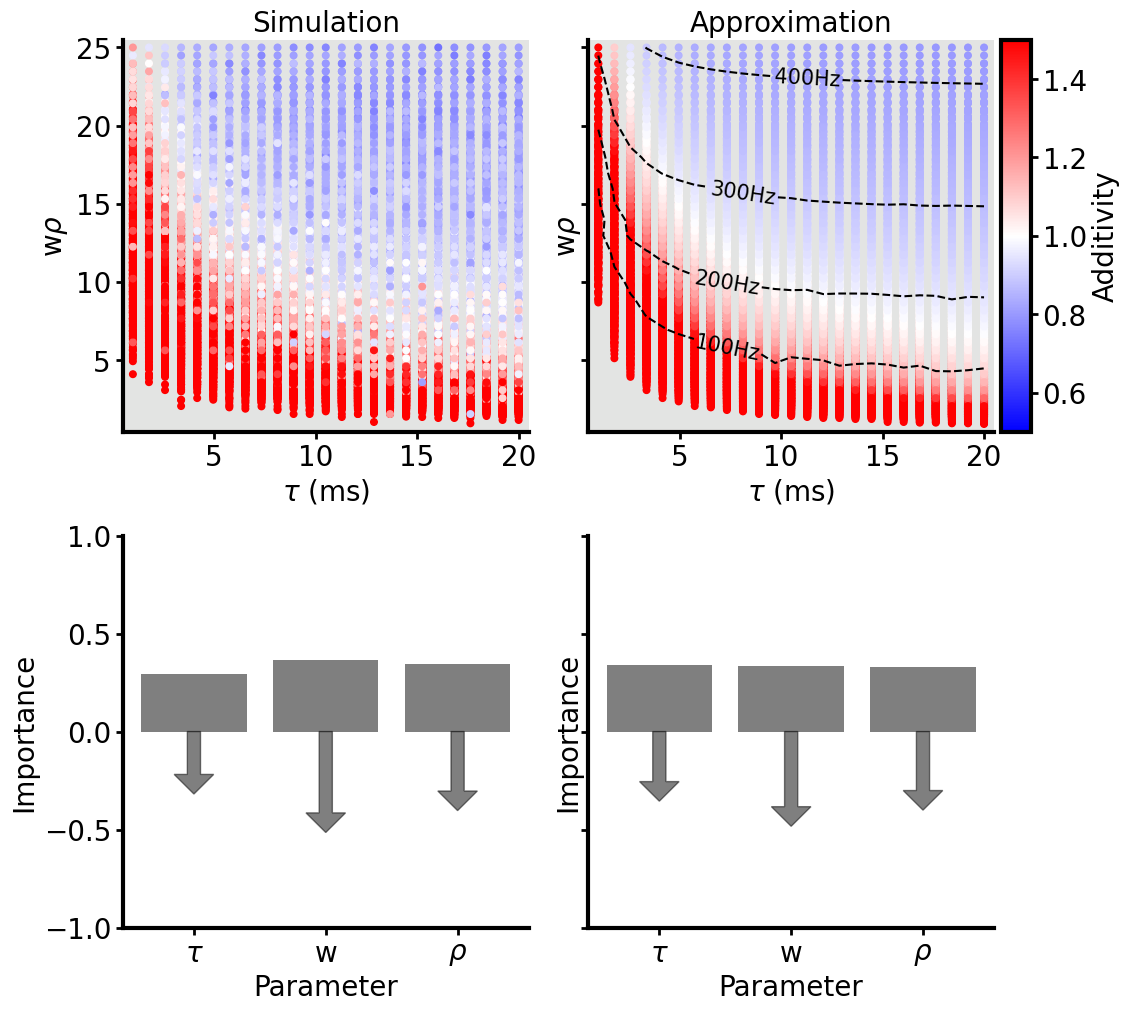

In [10]:
fig, ax = plt.subplots(
    2, 2, figsize=(10, 10), sharex="none", sharey="row", constrained_layout=True
)

X_list = [X_sim, X_approx]
X_labels = ["Simulation", "Approximation"]

for a, X in enumerate(X_list):
    # Data
    print(X_labels[a])
    x = X["$\\tau$"] / ms
    y = X["w"] * X["$\\rho$"]

    # Scatter plots
    plt.sca(ax[0, a]), ax[0, a].set_facecolor((im_colors[0]))
    im = plt.scatter(
        x, y, c=X["y"], cmap="bwr", vmin=0.5, vmax=1.5, s=90, marker=".", alpha=1
    )

    plt.xlabel("$\\tau$ (ms)"), plt.ylabel("w" "$\\rho$")
    plt.title(X_labels[a])

    if a == 1:
        # Contours
        z = X["$\\rhom$"]
        xi = np.linspace(x.min(), x.max(), len(tau_ms))
        yi = np.linspace(y.min(), y.max(), len(tau_ms))
        zi = griddata((x, y), z, (xi[None, :], yi[:, None]), method="linear")
        cs = ax[0, a].contour(
            xi, yi, zi, levels=4, linewidths=1.5, linestyles="dashed", colors="k"
        )
        plt.clabel(cs, colors="k", inline=True, fmt="%.0f" + "Hz", fontsize=15)

        cax = fig.add_axes(
            [
                ax[0, a].get_position().x1 + 0.03,
                ax[0, a].get_position().y0,
                0.03,
                ax[0, a].get_position().height,
            ]
        )
        cbar = plt.colorbar(im, cax=cax)
        cbar.set_label("Additivity")

    # Axis limits
    plt.sca(ax[0, a]), plt.xlim([x.min() - 0.5, x.max() + 0.5])
    plt.sca(ax[0, a]), plt.ylim([y.min() - 0.5, y.max() + 0.5])

    # Regression
    plt.sca(ax[1, a])
    X_train, X_test, y_train, y_test = train_test_split(
        X[["$\\tau$", "w", "$\\rho$"]], X["y"], test_size=0.33
    )
    random_forest_model(X_train, X_test, y_train, y_test, ax[1, a])
    print(" ")

    plt.savefig("single_unit.svg")
